In [1]:
library(tidyverse)
library(ontologyIndex)
library(ontologySimilarity)
library(reshape2)
library(pheatmap)
library(viridis)
library(igraph)
library(RColorBrewer)
library(ggplot2)
library(ggrepel)
library(stringi)
library(dplyr)
library(mclust)
library(factoextra)
library(grid)
library(wordcloud)
library(stringr)
library(Cairo)
library(dbplyr)
library(RPostgreSQL)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: viridisLite

Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    un

In [2]:
d=read_delim("../../../ontology_enrichment/analysis//significantly_enriched_terms.DEK1_targets.Benjamini-Hochberg.txt",delim="\t",col_types=cols())
head(d)


group        set        method             cutoff ontology ID        
1 DEK1_targets background Benjamini-Hochberg 0.1    GO       GO:0000271
2 DEK1_targets background Benjamini-Hochberg 0.1    GO       GO:0000910
3 DEK1_targets background Benjamini-Hochberg 0.1    GO       GO:0003824
4 DEK1_targets background Benjamini-Hochberg 0.1    GO       GO:0003899
5 DEK1_targets background Benjamini-Hochberg 0.1    GO       GO:0005576
6 DEK1_targets background Benjamini-Hochberg 0.1    GO       GO:0005829
  Pop.total Pop.term Study.total Study.term ⋯ is.trivial p           
1 27456       731    24022        624       ⋯ FALSE      9.620646e-05
2 27456       273    24022        245       ⋯ FALSE      4.015830e-05
3 27456     10423    24022       8966       ⋯ FALSE      1.440802e-09
4 27456       137    24022        129       ⋯ FALSE      2.039552e-07
5 27456      4514    24022       4094       ⋯ FALSE      3.136877e-14
6 27456      9834    24022       8670       ⋯ FALSE      1.732447e-08
  p.adjusted   p.min         depth ic       partition         
1 2.798646e-02  0.000000e+00 11    6.140708 biological_process
2 1.401846e-02 4.221749e-267  5    5.795868 biological_process
3 2.102398e-06  0.000000e+00  1    1.722104 molecular_function
4 1.779917e-04 2.501214e-240 29    7.875309 molecular_function
5 1.368776e-10  0.000000e+00  1    5.447561 cellular_component
6 1.679897e-05  0.000000e+00  7    5.809854 cellular_component
  level3                    name                                      
1 primary metabolic process polysaccharide biosynthetic process       
2 cell cycle                cytokinesis                               
3 NA                        catalytic activity                        
4 transferase activity      DNA-directed 5'-3' RNA polymerase activity
5 NA                        extracellular region                      
6 cell part                 cytosol                                   
  loci                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [3]:
table(d$group)


                DEK1_targets       DEK1_targets_direction 
                         252                          658 
                FDGENEA_0.01                  FDGENEA_0.1 
                        4477                         4739 
          final_DEK1_targets final_DEK1_targets_direction 
                         402                          879 
                    profiles      subnetwork_deregulation 
                         176                         1212 
         subnetwork_profiles        subnetwork_regulation 
                        1111                         4132 
                 subnetworks 
                        3833 

In [4]:
set.seed(27042012)

In [5]:
go=get_ontology("ontologies/go.obo", propagate_relationships=get_relation_names("ontologies/go.obo")[-c(4)])
po=get_ontology("ontologies/po.obo", propagate_relationships=get_relation_names("ontologies/po.obo")[-c(4)])

Warning message in (function (parents, id = names(parents), name = id, obsolete = setNames(nm = id, :
“Some parent terms not found: NCBITaxon:3398, NCBITaxon:33090”

In [6]:
goic=descendants_IC(go)
poic=descendants_IC(po)

In [7]:
d=d %>% filter( ontology != "TO") %>% 
    filter(group %in% c("final_DEK1_targets_direction","final_DEK1_targets") & set != "background")
d=droplevels(d)

In [8]:
G=d %>% separate_rows(loci,sep=",")

In [9]:
con = dbConnect(PostgreSQL(),dbname = 'dl', 
                 host = 'pgsbdb1',
                 port = 5432)

In [10]:
GG=G %>% rename("analysis"="group","gene_set"="set","id"="ID","geneid"="loci","p_adjusted"="p.adjusted","study_terms"="Study.term") %>% 
     select(analysis,gene_set,ontology,partition,id,name,level3,ic,depth,study_terms,p_adjusted,geneid)
head(GG)

analysis           gene_set ontology partition          id        
1 final_DEK1_targets targets  GO       biological_process GO:0000003
2 final_DEK1_targets targets  GO       biological_process GO:0000003
3 final_DEK1_targets targets  GO       biological_process GO:0000003
4 final_DEK1_targets targets  GO       biological_process GO:0000003
5 final_DEK1_targets targets  GO       biological_process GO:0000003
6 final_DEK1_targets targets  GO       biological_process GO:0000003
  name         level3 ic       depth study_terms p_adjusted geneid           
1 reproduction NA     3.581052 1     509         0.0201748  Pp3c5_24590.mRNA 
2 reproduction NA     3.581052 1     509         0.0201748  Pp3c9_410.mRNA   
3 reproduction NA     3.581052 1     509         0.0201748  Pp3c16_2360.mRNA 
4 reproduction NA     3.581052 1     509         0.0201748  Pp3c23_10580.mRNA
5 reproduction NA     3.581052 1     509         0.0201748  Pp3c10_2340.mRNA 
6 reproduction NA     3.581052 1     509         0.0201748  Pp3c4_17790.mRNA

Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”

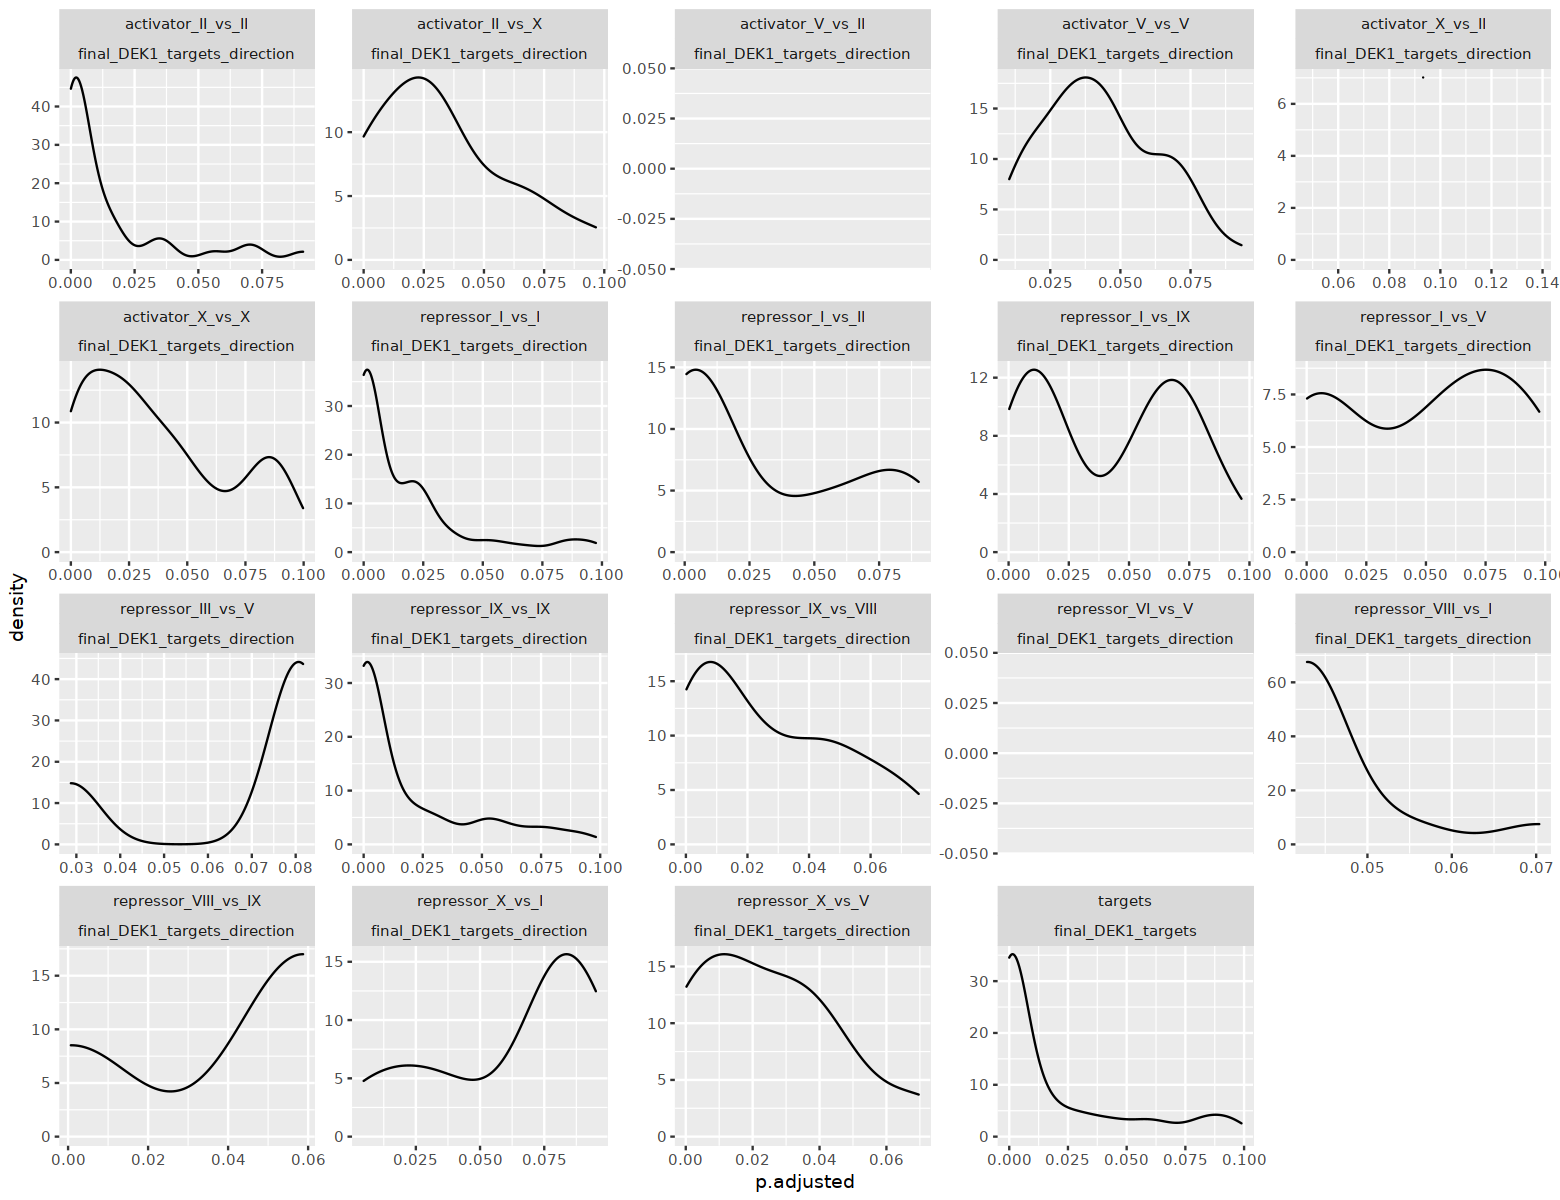

In [12]:
options(repr.plot.width=13, repr.plot.height=10)
ggplot(d,aes(p.adjusted)) + 
geom_density(alpha=0.5) + 
facet_wrap(set~group,scales="free") + 
scale_fill_brewer(palette="Set1")

In [13]:
O=list(GO=go,PO=po)
Oi=list(GO=goic,PO=poic)

## Individual enriched terms

[1] 55

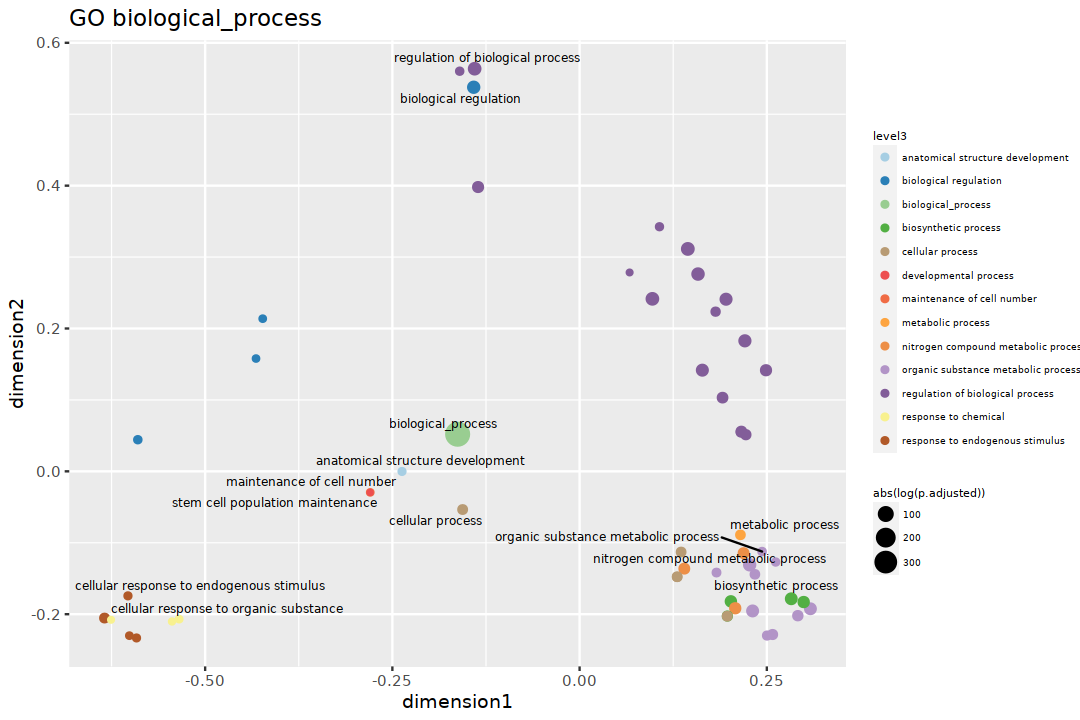

In [19]:
options(repr.plot.width=9, repr.plot.height=6)
group="final_DEK1_targets"
set="targets"
ontology="GO"
partition="biological_process"
#partition="plant anatomical entity"
fdr_cut=1e-3
D=droplevels(d[d$group==group & d$set==set & d$ontology==ontology & d$partition==partition & d$p.adjusted< fdr_cut,])
nrow(D)
D=D[order(D$p.adjusted),]
D$level3=factor(ifelse(is.na(D$level3),D$name,D$level3))
D=D %>%
    group_by(level3) %>%
    mutate(rank = order(order(ic,abs(log(p.adjusted)),  decreasing=FALSE)))

#D$rank=rank(-D$ic,D$p.adjusted)
D$term_fil=""
D$term_fil[D$rank==1]=as.character(D$name[D$rank==1])
tm=get_term_sim_mat(O[[ontology]],Oi[[ontology]] , method = "lin", row_terms = D$ID, col_terms = D$ID)
TM=max(tm)-tm
dimnames(TM)=list(O[[ontology]]$name[rownames(TM)],O[[ontology]]$name[colnames(TM)])
TM=as.dist(TM)
fit= cmdscale(TM,eig=TRUE, k=2) 
df=merge(fit$points,D,by.x=0,by.y="name")
names(df)[1:3]=c("term","dimension1","dimension2")
df=df[order(df$p.adjusted),]
colcount=length(unique(df$level3))
getPalette = colorRampPalette(brewer.pal(12, "Paired"))

p=ggplot(df,aes(x=dimension1,y=dimension2,label=term_fil)) +geom_point(aes(colour=level3,size=abs(log(p.adjusted)))) +
    scale_colour_manual(values=getPalette(colcount), guide= guide_legend(ncol=1) )+
    geom_text_repel(size=2.5,force=2) + 
    theme(legend.text=element_text(size=5),legend.title = element_text(size = 6), legend.key.size = unit(0.5, "cm")) + 
    ggtitle(paste(ontology,partition))
p
ggsave(p,filename ="final_DEK1_targets.BP.MDS.pdf",width=9,height=6)

In [20]:
#numbers of enriched terms with level3
table(D$level3)


   anatomical structure development               biological regulation 
                                  1                                   4 
                 biological_process                biosynthetic process 
                                  1                                   4 
                   cellular process               developmental process 
                                  5                                   1 
         maintenance of cell number                   metabolic process 
                                  1                                   1 
nitrogen compound metabolic process organic substance metabolic process 
                                  3                                  10 
   regulation of biological process                response to chemical 
                                 17                                   3 
    response to endogenous stimulus 
                                  4 

png 
  2

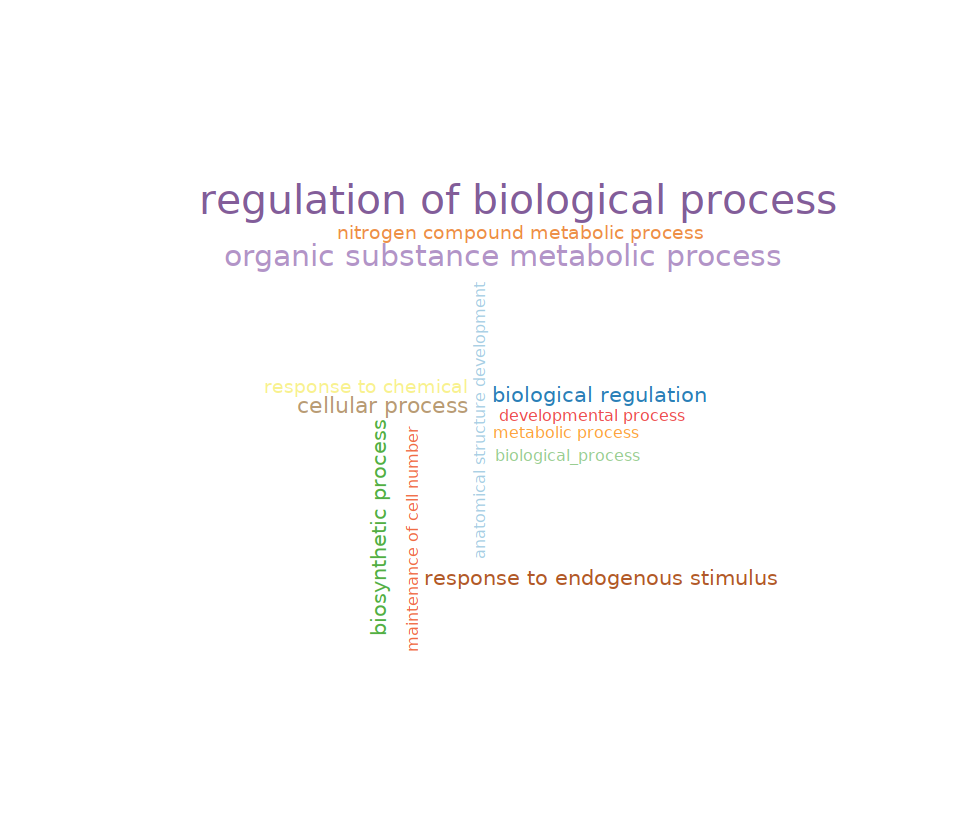

In [21]:
x=table(D$level3)
options(repr.plot.width=8, repr.plot.height=7)
wordcloud(words = names(x), freq = x, min.freq = 1, scale=c(2,.7),
          max.words=200, random.order=TRUE, rot.per=0.25, 
          colors=getPalette(colcount)[seq_len(length(x))],ordered.colors=TRUE)
pdf("final_DEK1_targets.BP.level3.word_cloud.pdf",width=8,height=8)
wordcloud(words = names(x), freq = x, min.freq = 1, scale=c(2,.7),
          max.words=200, random.order=TRUE, rot.per=0.25, 
          colors=getPalette(colcount)[seq_len(length(x))],ordered.colors=TRUE)
dev.off()

[1] 43

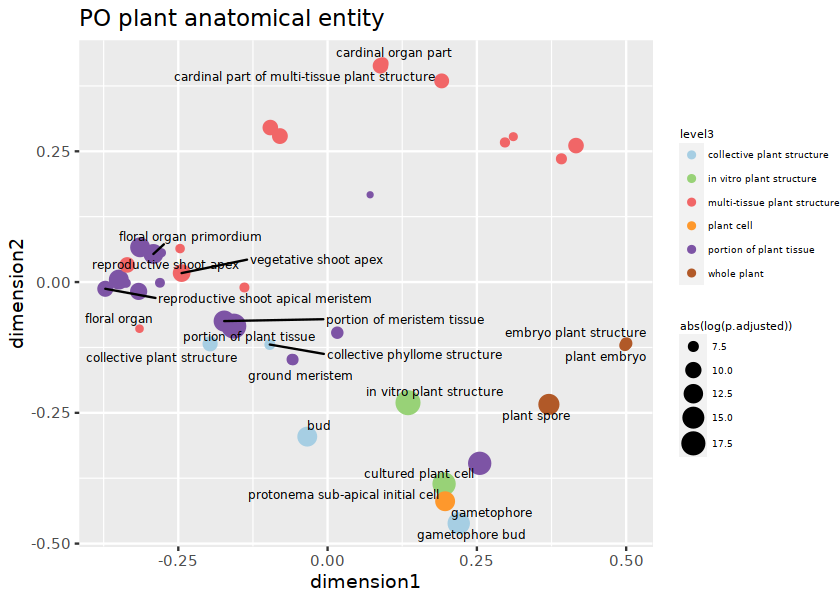

In [112]:
group="final_DEK1_targets"
set="targets"
ontology="PO"
partition="plant anatomical entity"
fdr_cut=1e-3
D=droplevels(d[d$group==group & d$set==set & d$ontology==ontology & d$partition==partition & d$p.adjusted< fdr_cut,])
nrow(D)
D=D[order(D$p.adjusted),]
D$level3=factor(ifelse(is.na(D$level3),D$name,D$level3))
D=D %>%
    group_by(level3) %>%
    mutate(rank = order(order(ic,abs(log(p.adjusted)),  decreasing=FALSE)))%>%
    ungroup() %>%
    group_by(level3,loci) %>%
    mutate(grank = order(order(ic,abs(log(p.adjusted)),  decreasing=FALSE)))%>%
    ungroup()
    

#D$rank=rank(-D$ic,D$p.adjusted)
D$term_fil=""
D$term_fil[D$rank<6]=as.character(D$name[D$rank<6])
tm=get_term_sim_mat(O[[ontology]],Oi[[ontology]] , method = "lin", row_terms = D$ID, col_terms = D$ID)
TM=max(tm)-tm
dimnames(TM)=list(O[[ontology]]$name[rownames(TM)],O[[ontology]]$name[colnames(TM)])
TM=as.dist(TM)
fit= cmdscale(TM,eig=TRUE, k=2) 
df=merge(fit$points,D,by.x=0,by.y="name")
names(df)[1:3]=c("term","dimension1","dimension2")
df=df[order(df$p.adjusted),]
colcount=length(unique(df$level3))
getPalette = colorRampPalette(brewer.pal(12, "Paired"))

p=ggplot(df,aes(x=dimension1,y=dimension2,label=term_fil)) +geom_point(aes(colour=level3,size=abs(log(p.adjusted)))) +
    scale_colour_manual(values=getPalette(colcount), guide= guide_legend(ncol=1) )+
    geom_text_repel(size=2.5,force=2) + 
    theme(legend.text=element_text(size=5),legend.title = element_text(size = 6), legend.key.size = unit(0.5, "cm")) + 
    ggtitle(paste(ontology,partition))
p
ggsave(p,filename ="final_DEK1_targets.PAE.MDS.pdf",width=9,height=6)

In [113]:
D %>% filter (ic>.53) %>% select(level3, rank,grank, term_fil,name,ic,Study.term,p.adjusted) %>% arrange(level3,grank,-Study.term)

level3                       rank grank
1  collective plant structure    3   1    
2  collective plant structure    5   1    
3  collective plant structure    4   1    
4  collective plant structure    2   1    
5  in vitro plant structure      1   1    
6  in vitro plant structure      2   2    
7  multi-tissue plant structure  1   1    
8  multi-tissue plant structure  5   1    
9  multi-tissue plant structure  2   1    
10 multi-tissue plant structure  4   1    
11 multi-tissue plant structure  7   1    
12 multi-tissue plant structure  8   1    
13 multi-tissue plant structure 12   1    
14 multi-tissue plant structure 10   1    
15 multi-tissue plant structure 15   1    
16 multi-tissue plant structure  9   1    
17 multi-tissue plant structure 16   1    
18 multi-tissue plant structure  6   2    
19 multi-tissue plant structure  3   2    
20 multi-tissue plant structure 11   2    
21 multi-tissue plant structure 13   2    
22 multi-tissue plant structure 14   2    
23 plant cell                    1   1    
24 portion of plant tissue       5   1    
25 portion of plant tissue      15   1    
26 portion of plant tissue       3   1    
27 portion of plant tissue       4   1    
28 portion of plant tissue       7   1    
29 portion of plant tissue      13   1    
30 portion of plant tissue      11   1    
31 portion of plant tissue      10   1    
32 portion of plant tissue      16   1    
33 portion of plant tissue       2   2    
34 portion of plant tissue       6   2    
35 portion of plant tissue       8   2    
36 portion of plant tissue      14   2    
37 portion of plant tissue      12   2    
38 portion of plant tissue       9   3    
39 whole plant                   3   1    
40 whole plant                   1   1    
41 whole plant                   2   1    
   term_fil                                     
1  bud                                          
2  gametophore                                  
3  gametophore bud                              
4  collective phyllome structure                
5  in vitro plant structure                     
6  cultured plant cell                          
7  reproductive shoot apex                      
8  vegetative shoot apex                        
9  cardinal part of multi-tissue plant structure
10 floral organ                                 
11                                              
12                                              
13                                              
14                                              
15                                              
16                                              
17                                              
18                                              
19 cardinal organ part                          
20                                              
21                                              
22                                              
23 protonema sub-apical initial cell            
24 ground meristem                              
25                                              
26 reproductive shoot apical meristem           
27 floral organ primordium                      
28                                              
29                                              
30                                              
31                                              
32                                              
33 portion of meristem tissue                   
34                                              
35                                              
36                                              
37                                              
38                                              
39 plant spore                                  
40 plant embryo                                 
41 embryo plant structure                       
   name                                          ic        Study.term
1  bud                                           3.5071133 3452      

In [114]:
nrow(D %>% filter (ic>.53 & nchar(term_fil)>1))

[1] 19

png 
  2

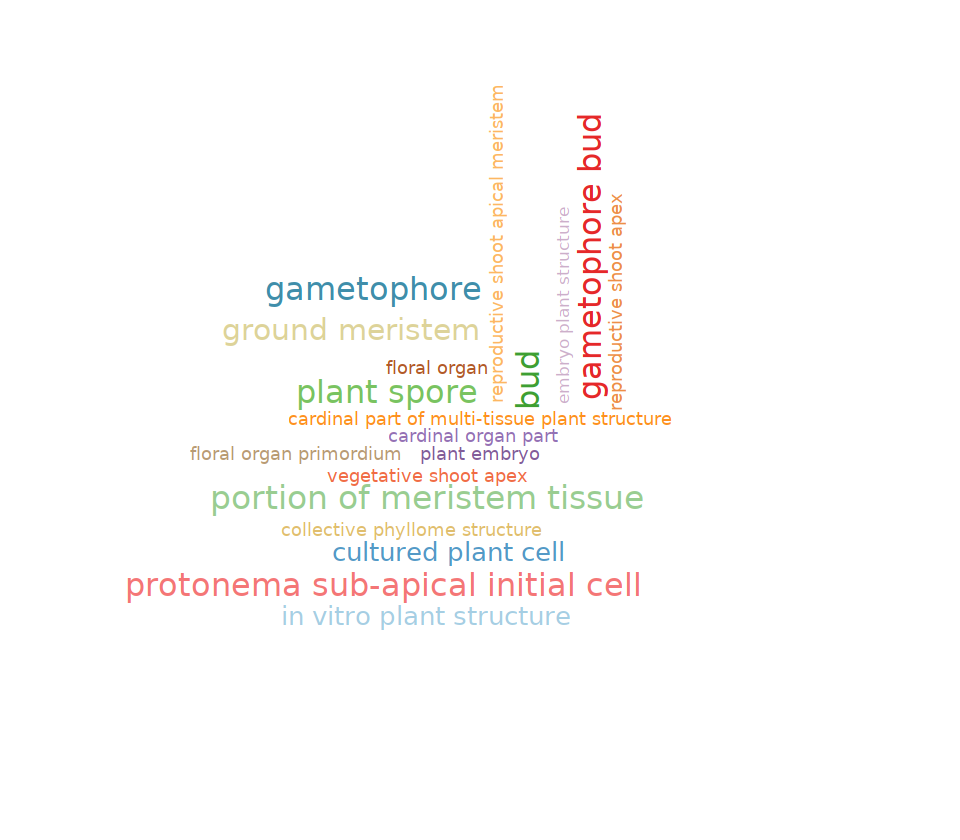

In [24]:
DD=D %>% filter (ic>.53 & nchar(term_fil)>1)

options(repr.plot.width=8, repr.plot.height=7)
wordcloud(words = DD$term_fil, freq = DD$Study.term, min.freq = 1, scale=c(1.6,.1),
          max.words=200, random.order=TRUE, rot.per=0.25, 
          colors=getPalette(nrow(DD))[seq_len(nrow(DD))],ordered.colors=TRUE)
pdf("final_DEK1_targets.PAE.terms_fil.word_cloud.pdf",width=8,height=8)
wordcloud(words = DD$term_fil, freq = DD$Study.term, min.freq = 1, scale=c(1.6,.1),
          max.words=200, random.order=TRUE, rot.per=0.25, 
          colors=getPalette(nrow(DD))[seq_len(nrow(DD))],ordered.colors=TRUE)
dev.off()

[1] 55

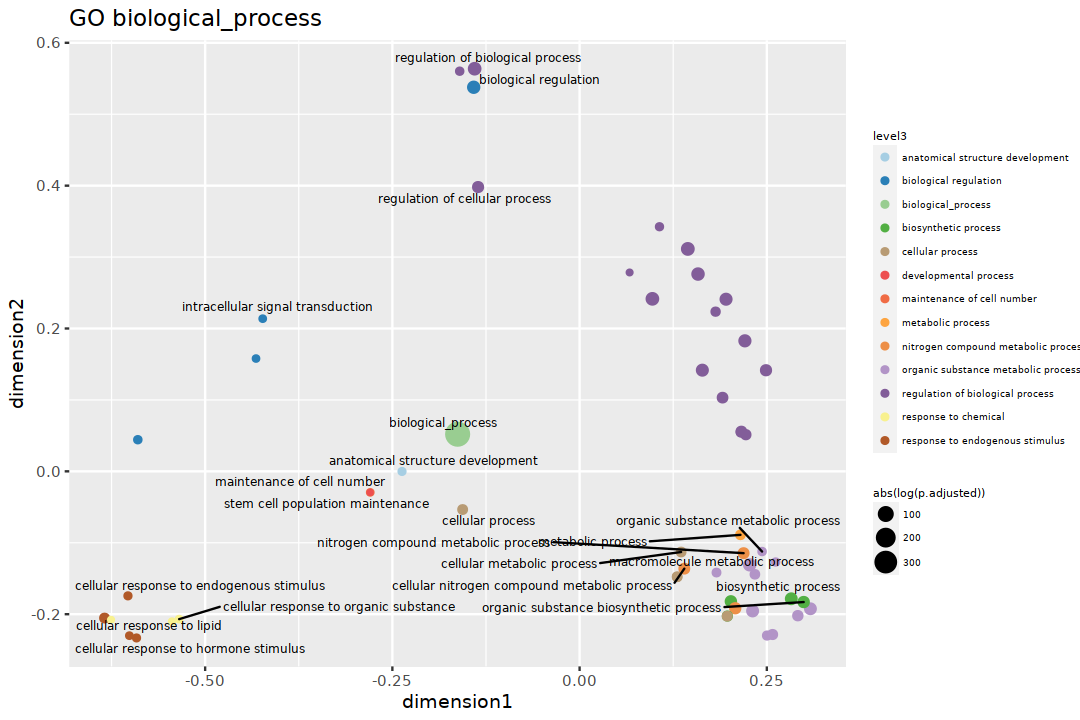

In [138]:

options(repr.plot.width=9, repr.plot.height=6)
group="final_DEK1_targets"
set="targets"
ontology="GO"
partition="biological_process"
fdr_cut=1e-3
D=droplevels(d[d$group==group & d$set==set & d$ontology==ontology & d$partition==partition & d$p.adjusted< fdr_cut,])
nrow(D)
D=D[order(D$p.adjusted),]
D$level3=factor(ifelse(is.na(D$level3),D$name,D$level3))
D=D %>%
    group_by(level3) %>%
    mutate(rank = order(order(ic,abs(log(p.adjusted)),  decreasing=FALSE)))%>%
    ungroup() %>%
    group_by(level3,loci) %>%
    mutate(grank = order(order(ic,abs(log(p.adjusted)),  decreasing=FALSE)))%>%
    ungroup()
    

#D$rank=rank(-D$ic,D$p.adjusted)
D$term_fil=""
D$term_fil[D$rank<3]=as.character(D$name[D$rank<3])
tm=get_term_sim_mat(O[[ontology]],Oi[[ontology]] , method = "lin", row_terms = D$ID, col_terms = D$ID)
TM=max(tm)-tm
dimnames(TM)=list(O[[ontology]]$name[rownames(TM)],O[[ontology]]$name[colnames(TM)])
TM=as.dist(TM)
fit= cmdscale(TM,eig=TRUE, k=2) 
df=merge(fit$points,D,by.x=0,by.y="name")
names(df)[1:3]=c("term","dimension1","dimension2")
df=df[order(df$p.adjusted),]
colcount=length(unique(df$level3))
getPalette = colorRampPalette(brewer.pal(12, "Paired"))

p=ggplot(df,aes(x=dimension1,y=dimension2,label=term_fil)) +geom_point(aes(colour=level3,size=abs(log(p.adjusted)))) +
    scale_colour_manual(values=getPalette(colcount), guide= guide_legend(ncol=1) )+
    geom_text_repel(size=2.5,force=2) + 
    theme(legend.text=element_text(size=5),legend.title = element_text(size = 6), legend.key.size = unit(0.5, "cm")) + 
    ggtitle(paste(ontology,partition))
p
ggsave(p,filename ="final_DEK1_targets.GO.MDS.pdf",width=9,height=6)

In [139]:
D %>% filter (ic>.53) %>% select(level3, rank,grank, term_fil,name,ic,Study.term,p.adjusted) %>% arrange(level3,grank,-Study.term)

level3                              rank grank
1  anatomical structure development     1   1    
2  biological regulation                1   1    
3  biological regulation                2   1    
4  biological regulation                3   1    
5  biological regulation                4   1    
6  biosynthetic process                 1   1    
7  biosynthetic process                 2   1    
8  biosynthetic process                 3   1    
9  biosynthetic process                 4   1    
10 cellular process                     1   1    
11 cellular process                     2   1    
12 cellular process                     3   1    
13 cellular process                     4   1    
14 cellular process                     5   1    
15 developmental process                1   1    
16 maintenance of cell number           1   1    
17 metabolic process                    1   1    
18 nitrogen compound metabolic process  1   1    
19 nitrogen compound metabolic process  2   1    
20 nitrogen compound metabolic process  3   1    
21 organic substance metabolic process  1   1    
22 organic substance metabolic process  2   1    
23 organic substance metabolic process  3   1    
24 organic substance metabolic process  4   1    
25 organic substance metabolic process  5   1    
26 organic substance metabolic process  7   1    
27 organic substance metabolic process  8   1    
28 organic substance metabolic process  6   1    
29 organic substance metabolic process  9   1    
30 organic substance metabolic process 10   1    
31 regulation of biological process     1   1    
32 regulation of biological process     2   1    
33 regulation of biological process     4   1    
34 regulation of biological process     7   1    
35 regulation of biological process     5   1    
36 regulation of biological process     6   1    
37 regulation of biological process    13   1    
38 regulation of biological process     8   1    
39 regulation of biological process     9   1    
40 regulation of biological process    11   1    
41 regulation of biological process    14   1    
42 regulation of biological process    15   1    
43 regulation of biological process    16   1    
44 regulation of biological process    17   1    
45 regulation of biological process     3   1    
46 regulation of biological process    10   1    
47 regulation of biological process    12   1    
48 response to chemical                 1   1    
49 response to chemical                 2   1    
50 response to chemical                 3   1    
51 response to endogenous stimulus      1   1    
52 response to endogenous stimulus      2   1    
53 response to endogenous stimulus      3   1    
54 response to endogenous stimulus      4   1    
   term_fil                                    
1  anatomical structure development            
2  biological regulation                       
3  intracellular signal transduction           
4                                              
5                                              
6  biosynthetic process                        
7  organic substance biosynthetic process      
8                                              
9                                              
10 cellular process                            
11 cellular metabolic process                  
12                                             
13                                             
14                                             
15 stem cell population maintenance            
16 maintenance of cell number                  
17 metabolic process                           
18 nitrogen compound metabolic process         
19 cellular nitrogen compound metabolic process
20                                             
21 organic substance metabolic process         
22 macromolecule metabolic process             
23                                             
24                                             
25                                             
26   

In [140]:
nrow(D %>% filter (ic>.53 & nchar(term_fil)>1))

[1] 20

png 
  2

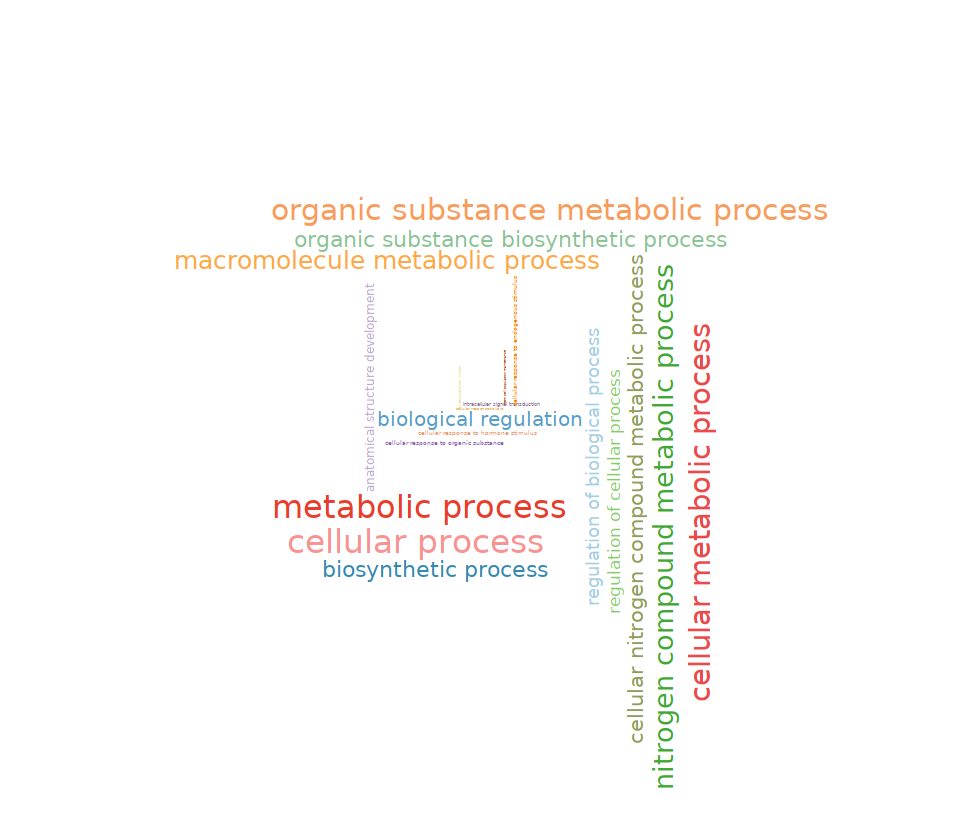

In [141]:
DD=D %>% filter (ic>.53 & nchar(term_fil)>1)

options(repr.plot.width=8, repr.plot.height=7)
wordcloud(words = DD$term_fil, freq = DD$Study.term, min.freq = 1, scale=c(1.6,.1),
          max.words=200, random.order=TRUE, rot.per=0.25, 
          colors=getPalette(nrow(DD))[seq_len(nrow(DD))],ordered.colors=TRUE)
pdf("final_DEK1_targets.GO.terms_fil.word_cloud.pdf",width=8,height=8)
wordcloud(words = DD$term_fil, freq = DD$Study.term, min.freq = 1, scale=c(1.6,.1),
          max.words=200, random.order=TRUE, rot.per=0.25, 
          colors=getPalette(nrow(DD))[seq_len(nrow(DD))],ordered.colors=TRUE)
dev.off()

## Clustering subnetwork sets

In [14]:
L=list()
dd=d %>% filter(partition %in% c("plant anatomical entity","biological_process"))
OP=as.data.frame(unique(dd[,c("partition","ontology")]))
for (p in unique(dd$partition )) {
    P=sapply(unique(dd$set), function(co) {
        q=dd[dd$set == co & dd$partition ==p,]
        return(unique(q$ID))
    })
    #P=P[lapply(P,length)>0]
    L[[p]]=P
}

L=L[lapply(L,length)>0]

In [15]:
LM=lapply(seq_len(nrow(OP)), function(i) {
    get_sim_grid(ontology=O[[OP[i,"ontology"]]], term_sets=L[[OP[i,"partition"]]])
    })
names(LM)=OP$partition

In [16]:
dsNbp=(LM[["plant anatomical entity"]]+LM[["biological_process"]])/2
dsNbp

targets   activator_II_vs_II activator_II_vs_X
targets              1.0000000 0.41411743         0.38096008       
activator_II_vs_II   0.4141174 0.50000000         0.40115268       
activator_II_vs_X    0.3809601 0.40115268         0.50000000       
activator_V_vs_II    0.2890944 0.30724726         0.23246429       
activator_V_vs_V     0.6690052 0.08821515         0.07935038       
activator_X_vs_II    0.3131325 0.33232911         0.29547645       
activator_X_vs_X     0.6783778 0.34052215         0.34537868       
repressor_I_vs_I     0.8208216 0.40622009         0.37365594       
repressor_I_vs_II    0.3882319 0.40259589         0.36069838       
repressor_I_vs_IX    0.6695982 0.34125868         0.32230938       
repressor_I_vs_V     0.3811075 0.37157734         0.34656512       
repressor_IX_vs_IX   0.7949069 0.32802278         0.35187595       
repressor_IX_vs_VIII 0.3326099 0.34802654         0.32537690       
repressor_VI_vs_V    0.2709917 0.23680346         0.22220745       
repressor_VIII_vs_I  0.2403410 0.21205992         0.21032622       
repressor_X_vs_I     0.3150329 0.30163610         0.23347544       
repressor_X_vs_V     0.2391551 0.15696649         0.15061846       
repressor_III_vs_V   0.2578642 0.00000000         0.00000000       
repressor_VIII_vs_IX 0.2708643 0.00000000         0.00000000       
                     activator_V_vs_II activator_V_vs_V activator_X_vs_II
targets              0.28909438        0.66900521       0.31313250       
activator_II_vs_II   0.30724726        0.08821515       0.33232911       
activator_II_vs_X    0.23246429        0.07935038       0.29547645       
activator_V_vs_II    0.50000000        0.03064264       0.03642951       
activator_V_vs_V     0.03064264        1.00000000       0.09333372       
activator_X_vs_II    0.03642951        0.09333372       0.50000000       
activator_X_vs_X     0.23354639        0.37591446       0.28623350       
repressor_I_vs_I     0.30154469        0.39777927       0.30161512       
repressor_I_vs_II    0.09191541        0.09400719       0.37189044       
repressor_I_vs_IX    0.31287599        0.16220536       0.24094076       
repressor_I_vs_V     0.33304258        0.05998468       0.22719417       
repressor_IX_vs_IX   0.20262278        0.50299711       0.26370483       
repressor_IX_vs_VIII 0.22173103        0.06478922       0.24316881       
repressor_VI_vs_V    0.17999889        0.02482539       0.02823720       
repressor_VIII_vs_I  0.09560009        0.05849400       0.17657921       
repressor_X_vs_I     0.03574824        0.07802634       0.39933826       
repressor_X_vs_V     0.03900601        0.06497340       0.23294892       
repressor_III_vs_V   0.00000000        0.24419079       0.00000000       
repressor_VIII_vs_IX 0.00000000        0.07026424       0.00000000       
                     activator_X_vs_X repressor_I_vs_I repressor_I_vs_II
targets              0.67837779       0.8208216        0.38823191       
activator_II_vs_II   0.34052215       0.4062201        0.40259589       
activator_II_vs_X    0.34537868       0.3736559        0.36069838       
activator_V_vs_II    0.23354639       0.3015447        0.09191541       
activator_V_vs_V     0.37591446       0.3977793        0.09400719       
activator_X_vs_II    0.28623350       0.3016151        0.37189044       
activator_X_vs_X     1.00000000       0.6666685        0.27442625       
repressor_I_vs_I     0.66666850       1.0000000        0.39758240       
repressor_I_vs_II    0.27442625       0.3975824        0.50000000       
repressor_I_vs_IX    0.40276038       0.7333543        0.30678550       
repressor_I_vs_V     0.29849192       0.4162410        0.31018096       
repressor_IX_vs_IX   0.58983297       0.6201241        0.31165803       
repressor_IX_vs_VIII 0.29218620       0.3071639        0.31402572       
repressor_VI_vs_V    0.20236736       0.3048155        0.16685586       
repressor_VIII_vs_I  0.26782139       0.2190675        0.21873909       
repressor_X_v

In [17]:
library(fpc)
row=pamk(as.dist(max(LM[["biological_process"]])-LM[["biological_process"]]))
col=pamk(as.dist(max(LM[["plant anatomical entity"]])-LM[["plant anatomical entity"]]))

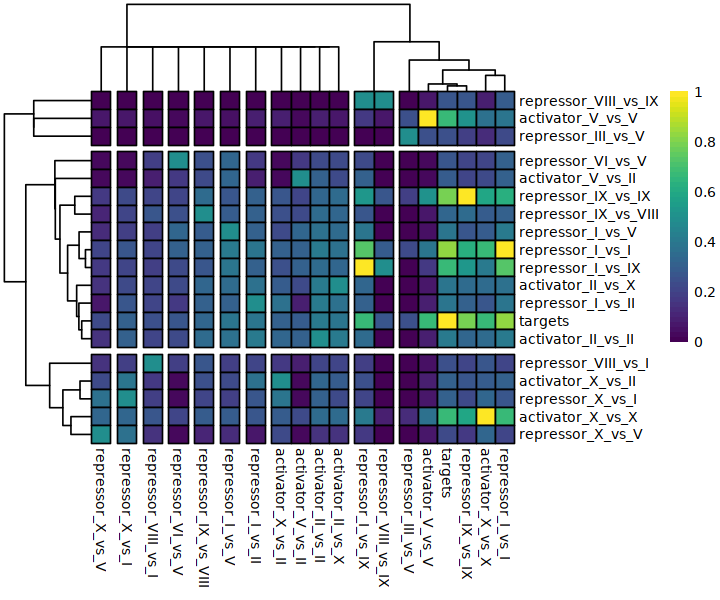

In [18]:
options(repr.plot.width=6, repr.plot.height=5)
pheatmap(dsNbp,
         border_col="black",
         color=viridis(50),
         clustering_distance_rows=as.dist(max(LM[["biological_process"]])-LM[["biological_process"]]),
         clustering_distance_cols=as.dist(max(LM[["plant anatomical entity"]])-LM[["plant anatomical entity"]]),
         clustering_method="ward.D2",
         fontsize = 8,
         scale="none",
         cutree_rows=as.numeric(row$nc),
         cutree_cols=as.numeric(col$nc)
         )
pheatmap(dsNbp,
         border_col="black",
         color=viridis(50),
         clustering_distance_rows=as.dist(max(LM[["biological_process"]])-LM[["biological_process"]]),
         clustering_distance_cols=as.dist(max(LM[["plant anatomical entity"]])-LM[["plant anatomical entity"]]),
         clustering_method="ward.D2",
         fontsize = 8,
         scale="none",
         cutree_rows=as.numeric(row$nc),
         cutree_cols=as.numeric(col$nc),
         filename="final_DEK_targets.BP.vs.PAE.similarities.pdf"
         )

In [25]:
col=read.csv("../../subnetwork_colours.csv",stringsAsFactors=FALSE)
col$network=ordered(col$network,levels=as.character(as.roman(1:11)))
col=col[order(col$network),]
col2=c("white",col$colour)
names(col2)=c(0,as.character(col$network))
col2

0         I        II       III        IV         V        VI       VII 
  "white" "#999999" "#FFE529" "#5A6A99" "#FF7F00" "#E486B7" "#6B886E" "#E41A1C" 
     VIII        IX         X        XI 
"#CA9A2C" "#AD5882" "#C66764" "#449B76"

In [26]:
length(table(d %>% filter(partition =="biological_process") %>% select(set)))

[1] 17

In [94]:
options(repr.plot.width=7, repr.plot.height=5)
D=droplevels(d[d$partition=="biological_process",])
nrow(D)
table(D$partition)
#
L=list()
OP=as.data.frame(unique(D[,c("partition","ontology")]))
for (p in unique(D$partition )) {
    P=sapply(unique(D$set), function(co) {
        q=D[D$set == co & D$partition ==p,]
        return(unique(q$ID))
    })
    #P=P[lapply(P,length)>0]
    L[[p]]=P
}

L=L[lapply(L,length)>0]

LM=lapply(seq_len(nrow(OP)), function(i) {
    get_sim_grid(ontology=O[[OP[i,"ontology"]]], term_sets=L[[OP[i,"partition"]]])
    })
names(LM)=OP$partition

st=D %>% group_by(set) %>% count() 
st=GG %>% filter(partition=="biological_process") %>% group_by(gene_set) %>% summarise(ngenes=length(unique(geneid))) %>% ungroup() %>% rename("set"="gene_set") 
nrow(st)
TM=max(LM[["biological_process"]])-LM[["biological_process"]]
n=rownames(TM)
N=gsub("repressor_(\\w+)_vs_(\\w+)","\\1⊣ \\2",perl=TRUE,gsub("activator_(\\w+)_vs_(\\w+)","\\1→\\2",perl=TRUE,rownames(TM)))
NN=str_match(rownames(TM),"(activator|repressor)_(\\w+)_vs_(\\w+)")[,3]
NNN=str_match(rownames(TM),"(activator|repressor)_(\\w+)_vs_(\\w+)")[,4]
NNNN=str_match(rownames(TM),"(activator|repressor)_(\\w+)_vs_(\\w+)")[,2]
rownames(TM)=N
colnames(TM)=N
TM=as.dist(TM)
TMD=tibble(set_name=as.character(N),set=n,type=ifelse(is.na(NNNN),"targets",NNNN),reg=as.character(NN),target=factor(ifelse(is.na(NNN),0,NNN),levels=c(0,as.character(as.roman(1:11)))))

fit= cmdscale(TM,eig=TRUE, k=2) 
df=tibble(set=rownames(fit$points),data.frame(fit$points))
nrow(df)
names(df)[1:3]=c("set_name","dimension1","dimension2")
df=inner_join(df,TMD,by="set_name")
nrow(df)
df=inner_join(df,st,by=c("set"))
nrow(df)
head(df)

[1] 696


biological_process 
               696 

[1] 17

[1] 17

[1] 17

[1] 17

set_name dimension1   dimension2  set                type      reg target
1 targets   0.006412453  0.14418926 targets            targets   NA  0     
2 II→II    -0.064757400 -0.09126874 activator_II_vs_II activator II  II    
3 II→X     -0.065124589 -0.09587183 activator_II_vs_X  activator II  X     
4 V→II     -0.434530574  0.09252274 activator_V_vs_II  activator V   II    
5 V→V       0.203709667  0.68365641 activator_V_vs_V   activator V   V     
6 X→II      0.358629356 -0.13722845 activator_X_vs_II  activator X   II    
  ngenes
1 3584  
2  269  
3  103  
4   36  
5   17  
6   40

In [95]:
mod=Mclust(data.frame(fit$points))

png 
  2

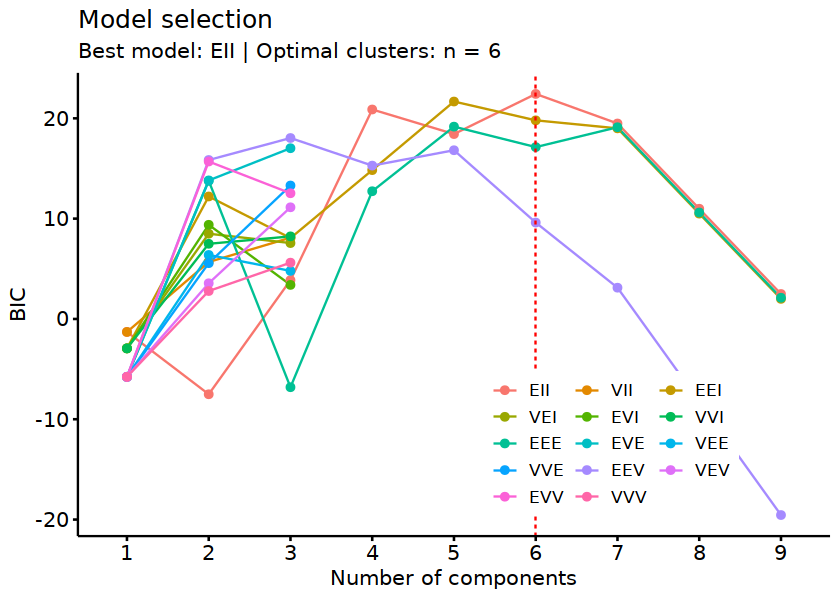

In [96]:
fviz_mclust_bic(mod)
pdf("final_DEK1_targets.sets.BP_semantic_similarity.MDS.mlcust.nclust.pdf")
fviz_mclust_bic(mod)
dev.off()

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse


png 
  2

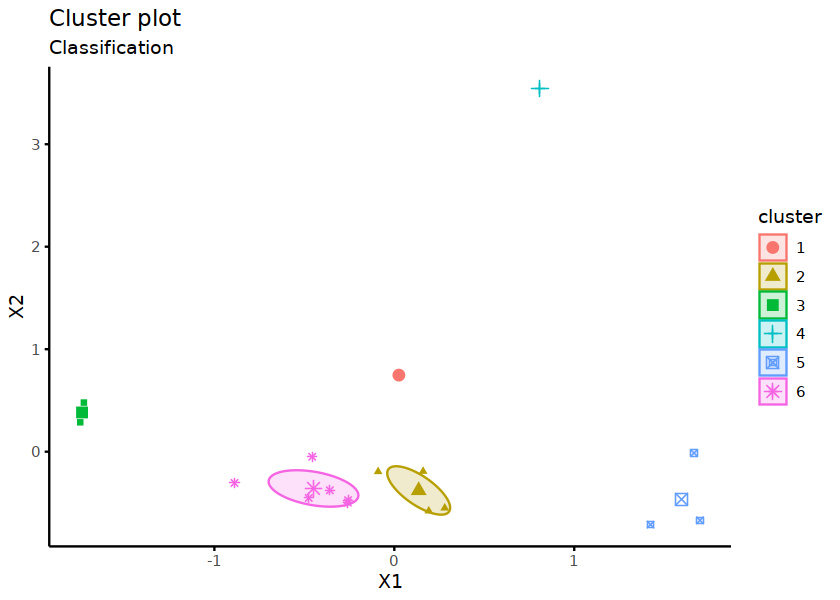

In [97]:
fviz_mclust(mod, "classification",geom="point" )
pdf("final_DEK1_targets.sets.BP_semantic_similarity.MDS.mlcust.plot.pdf")
fviz_mclust(mod, "classification",geom="point")
dev.off()

In [98]:
cl=tibble(set_name=names(mod$classification),cluster=factor(mod$classification))
df=merge(df,cl,by="set_name")
df

set_name dimension1   dimension2   set                  type      reg 
1  I⊣ I     -0.090208375 -0.072622939 repressor_I_vs_I     repressor I   
2  I⊣ II     0.048249686 -0.111437375 repressor_I_vs_II    repressor I   
3  I⊣ IX    -0.114959609 -0.009516646 repressor_I_vs_IX    repressor I   
4  I⊣ V     -0.223709451 -0.058724505 repressor_I_vs_V     repressor I   
5  II→II    -0.064757400 -0.091268738 activator_II_vs_II   activator II  
6  II→X     -0.065124589 -0.095871827 activator_II_vs_X    activator II  
7  IX⊣ IX   -0.022656180 -0.037456530 repressor_IX_vs_IX   repressor IX  
8  IX⊣ VIII -0.119769032 -0.087116022 repressor_IX_vs_VIII repressor IX  
9  targets   0.006412453  0.144189262 targets              targets   NA  
10 V→II     -0.434530574  0.092522737 activator_V_vs_II    activator V   
11 V→V       0.203709667  0.683656414 activator_V_vs_V     activator V   
12 VI⊣ V    -0.439631084  0.055347793 repressor_VI_vs_V    repressor VI  
13 VIII⊣ I   0.040317750 -0.036898669 repressor_VIII_vs_I  repressor VIII
14 X→II      0.358629356 -0.137228452 activator_X_vs_II    activator X   
15 X→X       0.070582747 -0.105918141 activator_X_vs_X     activator X   
16 X⊣ I      0.427936498 -0.129173996 repressor_X_vs_I     repressor X   
17 X⊣ V      0.419508136 -0.002482367 repressor_X_vs_V     repressor X   
   target ngenes cluster
1  I       129   6      
2  II       33   2      
3  IX      120   6      
4  V        81   6      
5  II      269   6      
6  X       103   6      
7  IX      307   2      
8  VIII     26   6      
9  0      3584   1      
10 II       36   3      
11 V        17   4      
12 V        16   3      
13 I         7   2      
14 II       40   5      
15 X       251   2      
16 I         9   5      
17 V        33   5

In [99]:
#source("https://gist.githubusercontent.com/eliocamp/eabafab2825779b88905954d84c82b32/raw/8af496a49e72361e305b580c8701e2337b37fd77/new_aes.R")


activator repressor   targets 
        6        10         1 

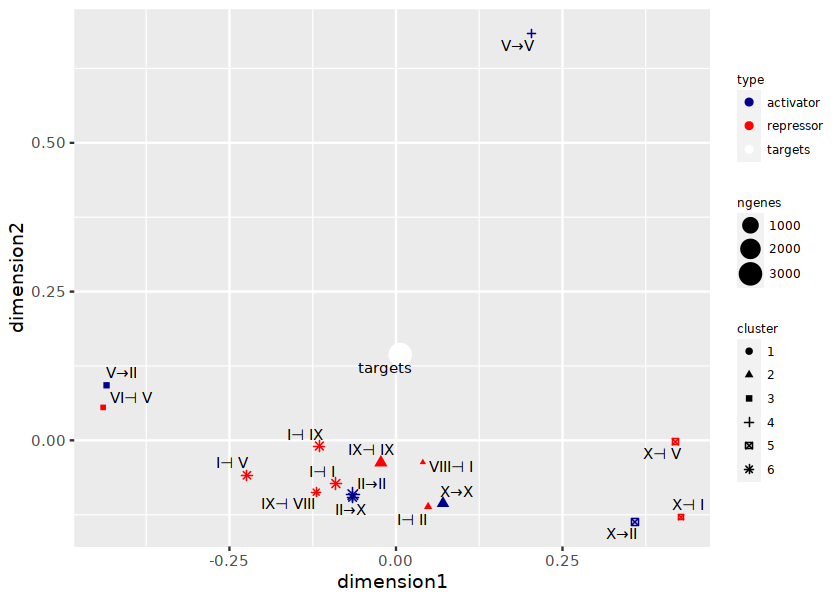

In [100]:
table(df$type)
col3=c("#00008b","#ff0000","white")
p=ggplot(df,aes(x=dimension1,y=dimension2,label=set_name)) +geom_point(aes(shape=cluster,colour=type,size=ngenes)) +
    geom_text_repel(size=3,force=2) + 
    scale_colour_manual(values=col3, guide= guide_legend(ncol=1) )+
    theme(legend.text=element_text(size=7),legend.title = element_text(size = 7), legend.key.size = unit(0.5, "cm"))  
p
ggsave(p,filename ="final_DEK1_targets.sets.BP_semantic_similarity.MDS.pdf",width=5,height=4,device=cairo_pdf)

In [101]:
DD=tibble(merge(df,D,by="set"))
head(DD)

set                set_name dimension1 dimension2  type      reg target
1 activator_II_vs_II II→II    -0.0647574 -0.09126874 activator II  II    
2 activator_II_vs_II II→II    -0.0647574 -0.09126874 activator II  II    
3 activator_II_vs_II II→II    -0.0647574 -0.09126874 activator II  II    
4 activator_II_vs_II II→II    -0.0647574 -0.09126874 activator II  II    
5 activator_II_vs_II II→II    -0.0647574 -0.09126874 activator II  II    
6 activator_II_vs_II II→II    -0.0647574 -0.09126874 activator II  II    
  ngenes cluster group                        ⋯ is.trivial p           
1 269    6       final_DEK1_targets_direction ⋯ FALSE      2.710125e-04
2 269    6       final_DEK1_targets_direction ⋯ FALSE      1.143922e-07
3 269    6       final_DEK1_targets_direction ⋯ FALSE      8.884959e-09
4 269    6       final_DEK1_targets_direction ⋯ FALSE      2.094735e-04
5 269    6       final_DEK1_targets_direction ⋯ FALSE      5.732668e-04
6 269    6       final_DEK1_targets_direction ⋯ FALSE      1.243948e-03
  p.adjusted   p.min         depth ic       partition         
1 1.889861e-02  0.000000e+00  2    4.358801 biological_process
2 5.041650e-05 5.744132e-262  6    3.371803 biological_process
3 9.293667e-06 9.476471e-190  9    3.968857 biological_process
4 1.565066e-02  3.655574e-28 21    8.819771 biological_process
5 3.634164e-02 6.288419e-310 10    8.568456 biological_process
6 7.228722e-02  1.366336e-34 15    8.057631 biological_process
  level3                           name                                   
1 NA                               response to endogenous stimulus        
2 regulation of biological process regulation of biosynthetic process     
3 regulation of biological process regulation of gene expression          
4 biological regulation            cytokinin-activated signaling pathway  
5 response to chemical             response to abscisic acid              
6 biological regulation            phosphorelay signal transduction system
  loci                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [110]:
DD %>% filter(cluster==5  & type=="activator") %>% select(set,level3,name,p.adjusted,ic) %>% arrange(set,p.adjusted)

set               level3                          
1 activator_X_vs_II regulation of biological process
2 activator_X_vs_II regulation of biological process
3 activator_X_vs_II reproductive process            
4 activator_X_vs_II cellular process                
5 activator_X_vs_II regulation of biological process
  name                                                      p.adjusted
1 regulation of cellular metabolic process                  0.09325697
2 regulation of cellular biosynthetic process               0.09325697
3 megasporogenesis                                          0.09325697
4 cytokinin biosynthetic process                            0.09325697
5 regulation of cellular macromolecule biosynthetic process 0.09325697
  ic       
1  2.757315
2  3.451128
3 10.765681
4  8.973922
5  4.094915

In [103]:
DD %>% filter(cluster==4 ) %>% select(set,level3,name,p.adjusted,ic) %>% arrange(set,p.adjusted)

set              level3 name          p.adjusted ic      
1 activator_V_vs_V NA     cell division 0.09315761 5.301849

In [106]:
DD %>% filter(cluster==6 & type=="activator" ) %>% select(set,level3,name,p.adjusted,ic) %>% arrange(set,p.adjusted)

set                level3                             
1  activator_II_vs_II regulation of biological process   
2  activator_II_vs_II regulation of biological process   
3  activator_II_vs_II regulation of biological process   
4  activator_II_vs_II regulation of biological process   
5  activator_II_vs_II regulation of biological process   
6  activator_II_vs_II organic substance metabolic process
7  activator_II_vs_II organic substance metabolic process
8  activator_II_vs_II biosynthetic process               
9  activator_II_vs_II regulation of biological process   
10 activator_II_vs_II response to abiotic stimulus       
11 activator_II_vs_II organic substance metabolic process
12 activator_II_vs_II regulation of biological process   
13 activator_II_vs_II organic substance metabolic process
14 activator_II_vs_II biosynthetic process               
15 activator_II_vs_II response to chemical               
16 activator_II_vs_II regulation of biological process   
17 activator_II_vs_II regulation of biological process   
18 activator_II_vs_II regulation of biological process   
19 activator_II_vs_II reproductive process               
20 activator_II_vs_II cellular process                   
21 activator_II_vs_II organic substance metabolic process
22 activator_II_vs_II response to abiotic stimulus       
23 activator_II_vs_II biological regulation              
24 activator_II_vs_II response to endogenous stimulus    
25 activator_II_vs_II NA                                 
26 activator_II_vs_II response to chemical               
27 activator_II_vs_II response to chemical               
28 activator_II_vs_II response to external stimulus      
29 activator_II_vs_II developmental process              
30 activator_II_vs_II response to chemical               
31 activator_II_vs_II biological regulation              
32 activator_II_vs_X  NA                                 
33 activator_II_vs_X  organic substance metabolic process
34 activator_II_vs_X  organic substance metabolic process
35 activator_II_vs_X  response to chemical               
36 activator_II_vs_X  organic substance metabolic process
37 activator_II_vs_X  response to stress                 
38 activator_II_vs_X  regulation of biological process   
39 activator_II_vs_X  response to endogenous stimulus    
40 activator_II_vs_X  biological regulation              
41 activator_II_vs_X  regulation of biological process   
   name                                                      p.adjusted  
1  regulation of cellular biosynthetic process               6.920951e-06
2  regulation of gene expression                             9.293667e-06
3  regulation of biosynthetic process                        5.041650e-05
4  regulation of macromolecule biosynthetic process          5.041650e-05
5  regulation of cellular macromolecule biosynthetic process 5.041650e-05
6  RNA biosynthetic process                                  6.267553e-05
7  transcription, DNA-templated                              7.006340e-05
8  nucleobase-containing compound biosynthetic process       1.339347e-04
9  regulation of nitrogen compound metabolic process         5.892200e-04
10 response to radiation                                     1.014367e-03
11 cellular protein modification process                     1.594550e-03
12 regulation of macromolecule metabolic process             1.594550e-03
13 organic cyclic compound biosynthetic process              1.594550e-03
14 heterocycle biosynthetic process                          1.708513e-03
15 response to oxygen-containing compound                    2.498584e-03
16 regulation of cellular metabolic process                  3.273171e-03
17 regulation of cellular process                            3.618954e-03
18 regulation of metabolic process                           6.108859e-03
19 cotyledon development                                     6.564302e-03
20 aromatic compound biosynthetic process                    6.890189e-03
21 protein mo

In [107]:
DD %>% filter(cluster==2 & type=="activator" ) %>% select(set,level3,name,p.adjusted,ic) %>% arrange(set,p.adjusted)

set              level3                                       
1   activator_X_vs_X NA                                           
2   activator_X_vs_X response to chemical                         
3   activator_X_vs_X response to chemical                         
4   activator_X_vs_X response to stress                           
5   activator_X_vs_X organic substance metabolic process          
6   activator_X_vs_X response to abiotic stimulus                 
7   activator_X_vs_X response to endogenous stimulus              
8   activator_X_vs_X NA                                           
9   activator_X_vs_X response to abiotic stimulus                 
10  activator_X_vs_X biosynthetic process                         
11  activator_X_vs_X organic substance metabolic process          
12  activator_X_vs_X NA                                           
13  activator_X_vs_X organic substance metabolic process          
14  activator_X_vs_X NA                                           
15  activator_X_vs_X cellular process                             
16  activator_X_vs_X cellular component organization or biogenesis
17  activator_X_vs_X NA                                           
18  activator_X_vs_X cellular component organization or biogenesis
19  activator_X_vs_X establishment of localization                
20  activator_X_vs_X response to stress                           
21  activator_X_vs_X cellular process                             
22  activator_X_vs_X cellular component organization or biogenesis
23  activator_X_vs_X response to chemical                         
24  activator_X_vs_X anatomical structure development             
25  activator_X_vs_X establishment of localization                
26  activator_X_vs_X macromolecule localization                   
27  activator_X_vs_X growth                                       
28  activator_X_vs_X anatomical structure development             
29  activator_X_vs_X regulation of biological quality             
30  activator_X_vs_X NA                                           
⋮   ⋮                ⋮                                            
176 activator_X_vs_X reproductive process                         
177 activator_X_vs_X regulation of biological process             
178 activator_X_vs_X regulation of biological process             
179 activator_X_vs_X reproductive process                         
180 activator_X_vs_X developmental process                        
181 activator_X_vs_X organic substance metabolic process          
182 activator_X_vs_X regulation of biological process             
183 activator_X_vs_X biosynthetic process                         
184 activator_X_vs_X regulation of biological process             
185 activator_X_vs_X NA                                           
186 activator_X_vs_X biological regulation                        
187 activator_X_vs_X biological regulation                        
188 activator_X_vs_X response to chemical                         
189 activator_X_vs_X response to abiotic stimulus                 
190 activator_X_vs_X reproductive process                         
191 activator_X_vs_X regulation of biological process             
192 activator_X_vs_X cellular component organization or biogenesis
193 activator_X_vs_X anatomical structure development             
194 activator_X_vs_X cellular component organization or biogenesis
195 activator_X_vs_X anatomical structure development             
196 activator_X_vs_X anatomical structure development             
197 activator_X_vs_X response to biotic stimulus                  
198 activator_X_vs_X regulation of biological process             
199 activator_X_vs_X catabolic process                            
200 activator_X_vs_X regulation of biological process             
201 activator_X_vs_X NA                                           
202 activator_X_vs_X cellular component organization or biogenesis
203 activator_X_vs_X response to stress            

In [109]:
DD %>% filter(cluster==3  ) %>% select(set,level3,name,p.adjusted,ic) %>% arrange(set,p.adjusted)

set               level3             name                           
1 activator_V_vs_II NA                 response to endogenous stimulus
2 repressor_VI_vs_V response to stress response to osmotic stress     
  p.adjusted ic      
1 0.06614906 4.358801
2 0.04328304 6.622546

In [123]:
d %>% filter(set == "targets") %>% 
    select(-loci) %>%
    arrange(ontology, partition, level3, p.adjusted, -ic) %>%
    group_by(ontology,partition,level3) %>%
    mutate(rank = order(order(-ic,p.adjusted)))%>%
    ungroup() %>%
    arrange(ontology, partition, level3, rank, p.adjusted, -ic) %>%
    write_delim("final_DEK1_targets.enriched_PO_GO.tsv",delim="\t")

In [134]:
d %>% filter(group == "final_DEK1_targets_direction") %>% 
    select(-loci) %>%
    arrange(ontology, partition, set,level3, p.adjusted, -ic) %>%
    group_by(ontology,partition,set,level3) %>%
    mutate(rank = order(order(-ic,p.adjusted)))%>%
    ungroup() %>%
    arrange(ontology, partition, set, level3, rank, p.adjusted, -ic) %>%
    write_delim("final_DEK1_targets_direction.enriched_PO_GO.tsv",delim="\t")